In [1]:

%pylab inline

import tensorflow as tf
%matplotlib inline
import numpy as np
from collections import deque
from os import listdir
import functools

pylab.rcParams['figure.figsize'] = (10.0, 10.0)

import pylab
from tsne import bh_sne
from matplotlib import pyplot as plt
import pandas
import scipy
import numpy as np
import sklearn.manifold
import os
import gc
from time import gmtime, strftime
import seaborn as sns
from os import listdir
from os.path import isfile, join
import math
from scipy.stats.stats import pearsonr
import random as rand
import pyproj
import functools


def display(image, min = 0.0, max = 1.0):
    plt.imshow(image, cmap = plt.get_cmap('gray'), interpolation='nearest')
    plt.show()
    




def display(image):
    plt.imshow(image, cmap = plt.get_cmap('gray'), interpolation='nearest')
    plt.show()
    
def memoize(obj, maxlen = 2000):
    """A decorator to cache advice objects using the advice key"""
    cache = obj.cache = {}
    deck = obj.deck = deque([], maxlen = maxlen)

    @functools.wraps(obj)
    def memoizer(*args, **kwargs):
        key = args[0]
        if key not in cache:
            if len(deck) == deck.maxlen:
              del cache[deck.popleft()[0]]
            temp = obj(*args, **kwargs)
            cache[key] = temp
            deck.append((key, temp))
        return cache[key]

    return memoizer

@memoize
def load_mat_from_file(key):
    f = file("/home/isaac/Desktop/devika/ARCGIS/ArcGis/pickle_files/"+key+".npy","rb")
    return np.load(f)

@memoize
def get_file_containing(housex, housey):
#         print "house coords:", housex, housey
    for key in file_attributes:
        block = file_attributes[key]
    #         print block['xllcorner'], block['yllcorner']
        if block['xllcorner'] < housex < block['xllcorner'] + block['width']:
            if block['yllcorner'] < housey < block['yllcorner'] + block['height']:
                return key
    assert(1==0)

def imagex(housex, housey, block):
    return (int(housex)-block['xllcorner'])/5
def imagey(housex, housey, block):
    return (int(housey)-block['yllcorner'])/5



#housex and housey in meters
def get_heightmap_around(housex, housey, window_width_pixels = 28):
    
    def image_slice(key, housex, housey, radius = window_width_pixels/2):
        x = housex
        y = housey
        block = file_attributes[key]
        mat = load_mat_from_file(key)
        x1 = np.max([0,              imagex(x,y,block) - radius])
        x2 = np.min([block['ncols'], imagex(x,y,block) + radius])
        
        y1 = np.max([0,              imagey(x,y,block) - radius])
        y2 = np.min([block['nrows'], imagey(x,y,block) + radius])
        
        assert(x1 <= x2)
        assert(y1 <= y2)
        return  mat[block['nrows'] - y2:block['nrows'] - y1, x1:x2]
    
    window_width_feet = window_width_pixels * 5
    housex /= .3048 #convert to feet
    housey /= .3048
    x = housex
    y = housey
    ul = get_file_containing(x - window_width_feet/2, y - window_width_feet/2)
    ur = get_file_containing(x + window_width_feet/2, y - window_width_feet/2)
    ll = get_file_containing(x - window_width_feet/2, y + window_width_feet/2)
    lr = get_file_containing(x + window_width_feet/2, y + window_width_feet/2)

    for key in [ul, ur, ll, lr]:
        image = image_slice(key, x, y)
#         print image.shape
        if image.shape == (window_width_pixels, window_width_pixels):
            return image

    

    if ul == ur and lr == ll : # horizontal split


        result = np.zeros([window_width_pixels, window_width_pixels])
        upper_slice = image_slice(ul, housex, housey)
        lower_slice = image_slice(ll, housex, housey)
        
        result[:upper_slice.shape[0], :] = upper_slice
        result[ window_width_pixels - lower_slice.shape[0]:, :] = lower_slice


        return result
    elif ul == ll and ur == lr and ul != ur and ll != lr: # vertical split
        result = np.zeros([window_width_pixels, window_width_pixels])
        left_slice = image_slice(ll, housex, housey)
        right_slice = image_slice(ur, housex, housey)
#         print left_slice.shape
#         print right_slice.shape
        
        result[:, :left_slice.shape[1]] = left_slice
        result[:, window_width_pixels - right_slice.shape[1]:] = right_slice

#         plt.imshow(result)
#         plt.show()
#         display(result)

        return result
    else: # four way split
#         print "four way"
        ll_slice = image_slice(ll, housex, housey)
        ul_slice = image_slice(ul, housex, housey)
        lr_slice = image_slice(lr, housex, housey)
        ur_slice = image_slice(ur, housex, housey)
        
        result = np.zeros([window_width_pixels, window_width_pixels])
        result[:ll_slice.shape[0], :ll_slice.shape[1]] = ll_slice
        result[:lr_slice.shape[0], window_width_pixels - lr_slice.shape[1]:] = lr_slice
        
        result[window_width_pixels - ul_slice.shape[0]:, :ul_slice.shape[1]] = ul_slice
        result[window_width_pixels - ur_slice.shape[0]:, window_width_pixels - ur_slice.shape[1]:] = ur_slice
#         display(result)
        return result

        

def window_violated_chunk_borders(housex, housey):
    corners = [(housex-window_width_feet/2, housey-window_width_feet/2),
              (housex-window_width_feet/2, housey+window_width_feet/2),
              (housex+window_width_feet/2, housey+window_width_feet/2),
              (housex+window_width_feet/2, housey-window_width_feet/2)]
    files = map(lambda x: get_file_containing(x[0], x[1]), corners)
    return len(set(files)) > 1



file_attributes = {}

mypath = "/home/isaac/Desktop/devika/ARCGIS/ArcGis/ascii_files"
for filename in [f for f in listdir(mypath) if isfile(join(mypath, f))]: 
    attributes = {}
    with open(mypath + "/" + filename) as FileObj:
        for index, line in enumerate(FileObj):
            if(index < 6):
#                 print line
                attributes[line.split(" ")[0]] = int(line.split(" ")[-1][:-2])
            else:
                break # don't load the other lines into memory becuase that's a waste of time.

    attributes['width'] = attributes['ncols'] * attributes['cellsize']
    attributes['height'] = attributes['nrows'] * attributes['cellsize']
    file_attributes[filename] = attributes
print "loaded all file header attributes into dict"


def load_data(path, normalize_columns = False, only_columns_containing = ""):
    print("loading...")
    gc.collect() # collect garbage
    data = pandas.read_hdf(path, '/df')
    df = pandas.DataFrame(data)
    data_dict = {}
    for label in set(df._get_numeric_data().columns).union({'hcad'}):
        # union hcad to ensure that hcad col comes in even if not considered numerical
        # if label != 'hcad':
        if normalize_columns:
            column_data = df[label].astype(float)
            column_data -= np.min(column_data)
            data_dict[label] = column_data / np.max(column_data)
        else:
            data_dict[label] = df[label].astype(float)

        result = pandas.DataFrame.from_dict(data_dict)

    result = result.replace([np.inf, -np.inf], 1)
    
    result = result.sort(['hcad']).fillna(0)
    
    for label in result:
        if not only_columns_containing in str(label):
            result.drop([str(label)], axis = 1 , inplace= True)
    return result


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib
loaded all file header attributes into dict


loading...
Opening /home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad100_hist8x8.mat.hd in read-only mode
loading...
Opening /home/isaac/Dropbox/data_for_brian/meta/df_meta.hd in read-only mode
loading...
Opening /home/isaac/Dropbox/data_for_brian/y_df.hd in read-only mode
loading...
Opening /home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_200.hd in read-only mode
        mean_dpr_val
329940      0.009669
281709      0.004870
119054      0.000138
281718      0.000138
602730      0.000271
633490      0.000198
396309      0.000283
396310      0.000283
449391      0.018096
690984      0.000361
212340      0.018368
177065      0.018368
736237      0.018368
506676      0.006546
305432      0.005483
306657      0.005483
665506      0.007524
665543      0.006065
479897      0.006065
109105      0.005869
86515       0.002997
86516       0.002985
86517       0.003232
747589      0.006458
747590      0.005385
747591      0.005385
747592      0.004238
747593  

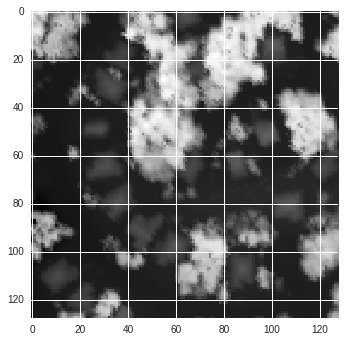

In [108]:
image_width = 128


wind_data = np.array(
    load_data("/home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad100_hist8x8.mat.hd", 
              normalize_columns=True, only_columns_containing = "spd")).astype(np.float32)
meta = load_data("/home/isaac/Dropbox/data_for_brian/meta/df_meta.hd")
y_data = load_data("/home/isaac/Dropbox/data_for_brian/y_df.hd")
hcad_dpr = load_data("/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_200.hd", 
              normalize_columns=True, only_columns_containing = "mean_dpr")
wind_data = np.concatenate((wind_data, hcad_dpr), axis = 1)


wgs84=pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth
UTM26N=pyproj.Proj("+init=EPSG:2278") # UTM coords, zone Texas Central, WGS84 datum

# lon = [meta['lon'][250000]] #these are good becuase of clear local features
# lat = [meta['lat'][250000]]


lon = [meta['lon'][12000]]
lat = [meta['lat'][12000]]

print "house lat lon", lat, lon
xx, yy = pyproj.transform(wgs84, UTM26N, lon, lat)
print xx, yy
housex=xx[0]
housey=yy[0]
display(get_heightmap_around(housex,housey, window_width_pixels = image_width))

n=10000



# metamat = metamat.astype(float32)
# metaY = np.zeros([len(meta)])



# for index in range(len(meta)):
    
# #     index = rand.randint(0, len(meta)-1)
#     lon = [meta['lon'][index]]
#     lat = [meta['lat'][index]]

#     xx, yy = pyproj.transform(wgs84, UTM26N, lon, lat)
#     housex=xx[0]
#     housey=yy[0]
    
    
#     new_element = get_heightmap_around(housex, housey, window_width_pixels=image_width)
#     if(new_element == None):
#         print index
#         break
#     if index%1000 == 0:
#         print index
        
    
    
#     new_element = np.array([new_element])
#     metamat[index] = new_element
#     metamat[index] = metamat[index] - np.min(metamat[index])

#     metaY[index] = y_data['y'][index]

In [3]:



def get_batch(batch_size = 100, random = True, start_index = 0):
    metamat = np.zeros([batch_size, image_width, image_width, 2]).astype(float32)
    metaY = np.zeros([batch_size,1]).astype(float32)
    extra_features = np.zeros([batch_size,len(wind_data[0])]).astype(float32)
    i = start_index
    for _ in range(batch_size):

        index = i
        if random:
            index = rand.randint(0, len(meta)-1)
        lon = [meta['lon'][index]]
        lat = [meta['lat'][index]]
        max_wind_speed = np.max(wind_data[index])
        metaY[i] = y_data['y200_mean'][index]
        extra_features[i] = wind_data[index]

        xx, yy = pyproj.transform(wgs84, UTM26N, lon, lat)
        housex=xx[0]
        housey=yy[0]

        lidar = None
        try:
            lidar = get_heightmap_around(housex, housey, window_width_pixels=image_width)
        except:
            pass
        if(lidar == None):
            continue
        lidar = lidar - np.min(lidar)
        lidar /= np.array([np.max(lidar)])

        lidar = np.array([lidar])
        metamat[i, :, :, 0] = lidar

        wind_data_channel = np.zeros([image_width, image_width]).astype(float32)
        wind_data_channel.fill(max_wind_speed)
        metamat[i, :, :, 1] = wind_data_channel



        i += 1

    #metamat = metamat.reshape([batch_size, image_width**2])

    return metamat, extra_features, metaY

'''
A Convolutional Network implementation example using TensorFlow library.
This example is using the MNIST database of handwritten digits
(http://yann.lecun.com/exdb/mnist/)

Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
'''

import tensorflow as tf


# Parameters
learning_rate = 0.01
training_iters = 200000
batch_size = 5
display_step = 10

# Network Parameters
n_input = image_width**2 # MNIST data input (img shape: 28*28)
n_classes = 1 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

# tf Graph input
image_data = tf.placeholder(tf.float32, [None, image_width, image_width, 2], name = 'image_data_placeholder')
extra_features = tf.placeholder(tf.float32, [None, len(wind_data[0])], name = 'extrafeatures_ph')
# extra_features = tf.placeholder(tf.float32, [None, 1], name = 'extrafeatures_ph')

y = tf.placeholder(tf.float32, [None,1], name = 'y_placeholder')
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)


def stack(input_mat, num_neurons, nonlinearity):
    weights = tf.Variable(tf.random_normal([int(input_mat.get_shape()[1]), num_neurons], stddev=0.35))
   # weight_variables.append(weights)
    biases = tf.Variable(tf.random_normal([num_neurons], stddev=0.35))
    return nonlinearity(tf.add(tf.matmul(input_mat, weights), biases))

# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, image_width, image_width, 2])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    print "conv2 shape", conv2.get_shape()
    
    
    conv3 = conv2d(conv2, tf.random_normal([5, 5, 16, 16]), tf.random_normal([16]))
    conv3 = maxpool2d(conv3, k=2)
    conv4 = conv2d(conv3, tf.random_normal([5, 5, 16, 16]), tf.random_normal([16]))
    conv4 = maxpool2d(conv4, k=2)
    print "conv4 shape", conv4.get_shape()

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv4, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)
    print "fc1 shape", fc1.get_shape()
    # Output, class prediction
    out = (tf.add(tf.matmul(fc1, weights['out']), biases['out']))
    return out

# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 2, 16])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 16, 16])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([8*8*16, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([16])),
    'bc2': tf.Variable(tf.random_normal([16])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model


conv_net_out = conv_net(image_data, weights, biases, keep_prob)


# pred = tf.concat(1, [stack(conv_net_out, 40, tf.nn.relu), 
#                            stack(stack(extra_features, 40, tf.nn.relu),40,tf.nn.relu)])
pred = stack(extra_features, 120, tf.nn.sigmoid)
# pred = stack(conv_net_out, 40, tf.nn.relu)
pred =  stack(pred,100,tf.nn.sigmoid)
pred =  stack(pred,1,tf.nn.sigmoid)

# Define loss and optimizer
cost = tf.reduce_mean(tf.square(tf.sub(pred, y)) )
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables

# Keep training until reach max iterations


#     print "Testing Accuracy:", \
#         sess.run(accuracy, feed_dict={x: mnist.test.images[:256],
#                                       y: mnist.test.labels[:256],
#                                       keep_prob: 1.})

conv2 shape (?, 32, 32, 16)
conv4 shape (?, 8, 8, 16)
fc1 shape (?, 1024)


In [18]:
init = tf.initialize_all_variables()
# Launch the graph
sess = tf.Session()
sess.run(init)

In [19]:
step = 1
while step * batch_size < training_iters:
    image_data_data, extra_features_data, batch_y = get_batch(batch_size=batch_size, random = False)

    sess.run(optimizer, feed_dict={image_data: image_data_data,
                                   extra_features: extra_features_data,
                                   y: batch_y,
                                   keep_prob: 1.})
    if step % max(display_step, 500) == 0:
        # Calculate batch loss and accuracy
        loss, acc = sess.run([cost, accuracy], feed_dict={image_data: image_data_data,
                                                          extra_features: extra_features_data,
                                                          y: batch_y,
                                                          keep_prob: 1.})
        print "Iter " + str(step*batch_size) + ", Minibatch Loss= ", loss #+ ", Training Accuracy= " #+ \
              #"{:.5f}".format(acc)
        #print "y avg", np.mean(batch_y[:,0])
    step += 1
print "Optimization Finished!"

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:29: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Iter 2500, Minibatch Loss=  0.02709
Iter 5000, Minibatch Loss=  0.0270749
Iter 7500, Minibatch Loss=  0.0270606
Iter 10000, Minibatch Loss=  0.0270605


KeyboardInterrupt: 

In [ ]:
plt.hist(y_predicted, bins = 50)
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:29: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


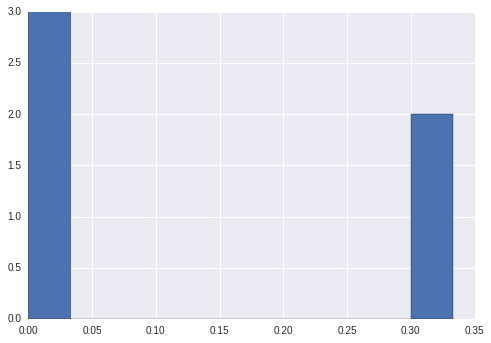

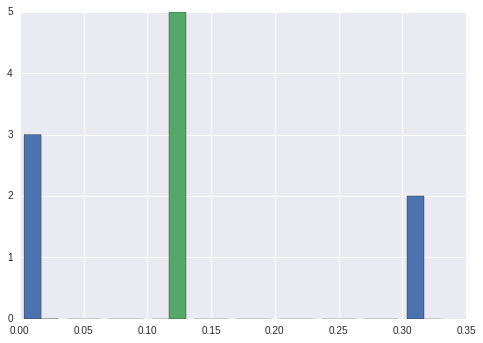

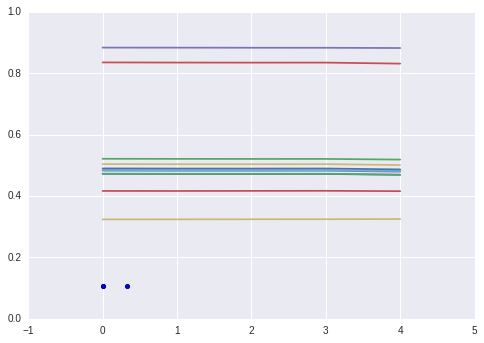

1.0
0.0
0.883689
0.323908
11


In [20]:
image_data_data, extra_features_data, batch_y = get_batch(batch_size=batch_size, random = False)
y_predicted = sess.run(pred, feed_dict={image_data: image_data_data,
                                   extra_features: extra_features_data,
                                   y: batch_y,
                                   keep_prob: dropout})

plt.hist(batch_y)
plt.show()
plt.hist([batch_y, y_predicted])
# plt.hist(y_predicted)
plt.show()

plt.scatter(batch_y, y_predicted)

# for i in range(len(extra_features_data[0])):
#     plt.scatter(batch_y, extra_features_data[:,i])
#     plt.show()
plt.plot(extra_features_data)
plt.show()


# plt.hist(np.max(get_batch(batch_size=batch_size)[1], axis = 1))
# plt.show()

print np.max(image_data_data)
print np.min(image_data_data)
print np.max(extra_features_data[0])
print np.min(extra_features_data)
print len(extra_features_data[0])


In [ ]:
y_predicted = []
for i in range(0,len(wind_data), batch_size):
    image_data_data, extra_features_data, batch_y = get_batch(batch_size=batch_size, random = False, start_index = i)
    y_predicted.extend([x[0] for x in sess.run(pred, feed_dict={image_data: image_data_data,
                                   extra_features: extra_features_data,
                                   y: batch_y,
                                   keep_prob: 1.0})])


    

In [118]:
import tflearn
tf.reset_default_graph()
# Data loading and preprocessing
image_data_data, extra_features_data, batch_y = get_batch(batch_size=20, random = False)
# batch_y = np.round(batch_y)
# for i in range(len(batch_y)):
#     extra_features_data[i].fill(batch_y[i][0])

X, Y = extra_features_data, batch_y
print X.shape
# Building deep neural network
input_layer = tflearn.input_data(shape=[None, 12])
dense1 = tflearn.fully_connected(input_layer, 164, activation='relu',
                                 regularizer='L2', weight_decay=0.0)
dense2 = tflearn.fully_connected(dense1, 164, activation='relu',
                                 regularizer='L2', weight_decay=0.0)
softmax = tflearn.fully_connected(dense2, 1, activation='tanh')

# Regression using SGD with learning rate decay and Top-3 accuracy
sgd = tflearn.RMSProp(learning_rate=0.001)
net = tflearn.regression(softmax, optimizer=sgd,
                         loss='mean_square')

# Training
model = tflearn.DNN(net, tensorboard_verbose=0)
model.fit(X, Y, n_epoch=1000, 
          show_metric=True, run_id="dense_model")

Training Step: 1000  | total loss: 0.00974
| RMSProp | epoch: 1000 | loss: 0.00974 - acc: 1.0000 -- iter: 20/20
Training Step: 1000  | total loss: 0.00974
| RMSProp | epoch: 1000 | loss: 0.00974 - acc: 1.0000 -- iter: 20/20
--


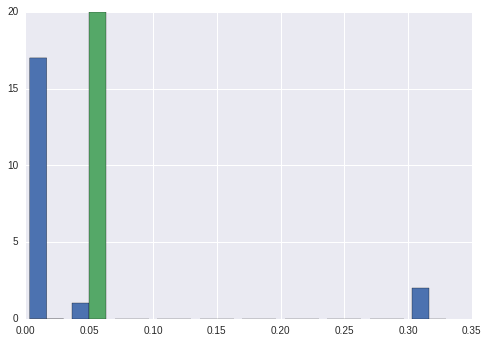

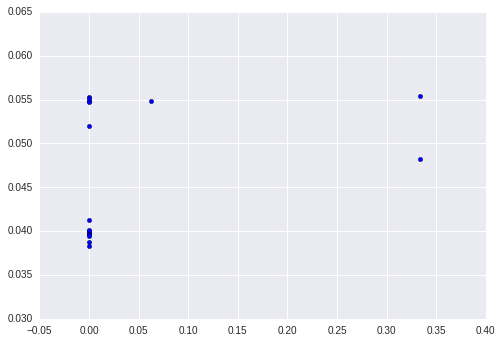

In [119]:
prediction = model.predict(X)
plt.hist([batch_y, prediction])
plt.show()
plt.scatter(batch_y,prediction)
plt.show()

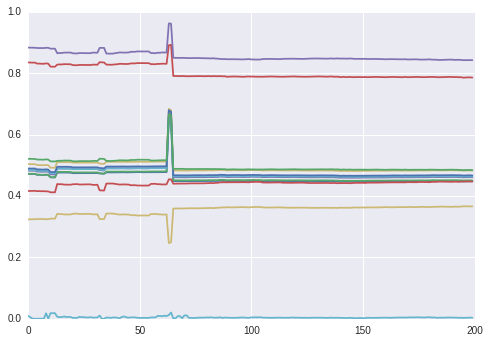

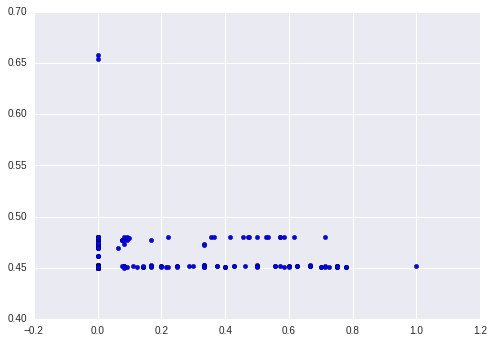

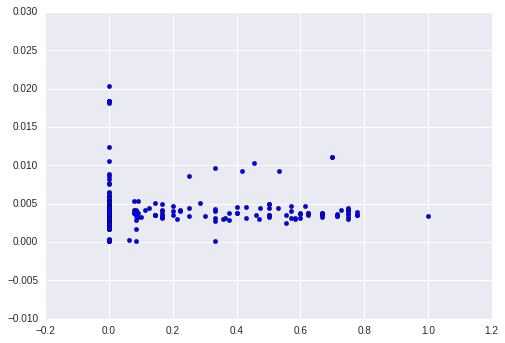

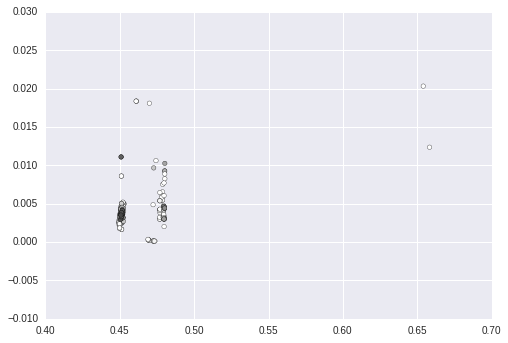

In [115]:
colors = np.zeros([len(batch_y), 3])
colors[:,0] = batch_y[:,0]
colors[:,1] = batch_y[:,0]
colors[:,2] = batch_y[:,0]



plt.plot(extra_features_data)
plt.show()
plt.scatter(batch_y, extra_features_data[:,1])
plt.show()
plt.scatter(batch_y, extra_features_data[:,-1])
plt.show()
plt.scatter(extra_features_data[:,1], extra_features_data[:,-1], c=batch_y[:,0])
plt.show()

In [1]:
import tflearn

X = [3.3,4.4,5.5,6.71,6.93,4.168,9.779,6.182,7.59,2.167,7.042,10.791,5.313,7.997,5.654,9.27,3.1]
Y = [1.7,2.76,2.09,3.19,1.694,1.573,3.366,2.596,2.53,1.221,2.827,3.465,1.65,2.904,2.42,2.94,1.3]

input_layer = tflearn.input_data(shape=[None])
linear_layer = tflearn.single_unit(input_layer)
regression_layer = tflearn.regression(linear_layer, optimizer="sgd", loss="mean_square",
                                      metric="R2", learning_rate=.01)

m = tflearn.DNN(regression_layer)
m.fit(X, Y, n_epoch=1000, show_metric=False, snapshot_epoch=False)

Training Step: 1000  | total loss: 0.15502
| SGD | epoch: 1000 | loss: 0.15502 -- iter: 17/17
